In [1]:
###THIS METRIC GETS THE TOXIC MESSAGE COUNT PER USER IN A REPO###
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
###USER PICKS REPO TO MEASURE THIS METRIC###
repoName = input("input repo name:")

input repo name: Loris


In [3]:
###GET TABLE OF ALL MESSAGES IN THIS REPO AND THEIR SENTIMENT SCORE###
repolist = pd.DataFrame()

repo_query = salc.sql.text(f"""
            SELECT
                repo.repo_id,
                repo.repo_name,
                date_trunc( 'month', message.msg_timestamp ) AS message_month,
                message.cntrb_id, 
                AVG (message_analysis.sentiment_score) AS average_sentiment
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                and 
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name,
                message.msg_timestamp, 
                message.cntrb_id 
            ORDER BY
                average_sentiment DESC,
                repo_id,
                message_month DESC;
    """)

repolist = pd.read_sql(repo_query, con=engine)

display(repolist)

repolist.dtypes

,repo_id,repo_name,message_month,cntrb_id,average_sentiment
0,26188,Loris,2019-11-01,298139,0.994333
1,26188,Loris,2020-03-01,397003,0.993386
2,26188,Loris,2016-12-01,303068,0.993256
3,26188,Loris,2020-05-01,297360,0.993102
4,26188,Loris,2018-09-01,297370,0.992395
...,...,...,...,...,...
16132,26188,Loris,2016-03-01,297198,-0.957898
16133,26188,Loris,2020-05-01,389737,-0.962243
16134,26188,Loris,2019-04-01,297219,-0.973245
16135,26188,Loris,2019-06-01,297206,-0.976898


repo_id                       int64
repo_name                    object
message_month        datetime64[ns]
cntrb_id                      int64
average_sentiment           float64
dtype: object

In [4]:
####THIS GETS A LIST OF ALL THE CONTRIBUTERS IN THE REPO###
repolist2 = pd.DataFrame()

repo_query2 = salc.sql.text(f"""
            SELECT 
                repo.repo_id,
                repo.repo_name,
                message.cntrb_id
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                AND
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name, 
                message.cntrb_id 
            ORDER BY
                repo_id
    """)

repolist2 = pd.read_sql(repo_query2, con=engine)

display(repolist2)

repolist.dtypes

,repo_id,repo_name,cntrb_id
0,26188,Loris,277109
1,26188,Loris,277456
2,26188,Loris,277532
3,26188,Loris,281788
4,26188,Loris,281876
...,...,...,...
117,26188,Loris,394582
118,26188,Loris,396107
119,26188,Loris,396858
120,26188,Loris,397003


repo_id                       int64
repo_name                    object
message_month        datetime64[ns]
cntrb_id                      int64
average_sentiment           float64
dtype: object

In [5]:
###THIS GIVES THE AVERAGE SENTIMENT OF ALL MESSAGES, THE TOTAL TOXIC MESSAGE COUNT, AND THE TOTAL MESSAGE COUNT###
#This isn't needed for this metric, but will be used in other metrics#
overall_score = sum(repolist.average_sentiment)/len(repolist.average_sentiment)

summ = 0
for i  in repolist.average_sentiment:
    if i < 0:
        summ = summ + 1

In [6]:
###THIS TALLIES UP THE TOXIC MESSAGES FOR EACH USER###
contribIDs = []
Toxic_Count_Array = []
print("Processing Message Data for " + str(len(repolist2.cntrb_id)) + " contributors. This may take some time");
for i in range(len(repolist2.cntrb_id)):
    if(i % 10 == 0):
        print(".")
    toxicCount = 0
    for j in range(len(repolist.cntrb_id)):
        if repolist.cntrb_id[j] == repolist2.cntrb_id[i]:
            if repolist.average_sentiment[j] < 0:
                toxicCount = toxicCount + 1
    contribIDs.append(str(repolist2.cntrb_id[i]))
    Toxic_Count_Array.append(toxicCount)
print("Done processing! Thank you for your patience")
average_toxic_count = sum(Toxic_Count_Array)/len(Toxic_Count_Array)
print("Here is the average count among all users: " + str(average_toxic_count))

Processing Message Data for 122 contributors. This may take some time
.
.
.
.
.
.
.
.
.
.
.
.
.
Done processing! Thank you for your patience
Here is the average count among all users: 7.549180327868853


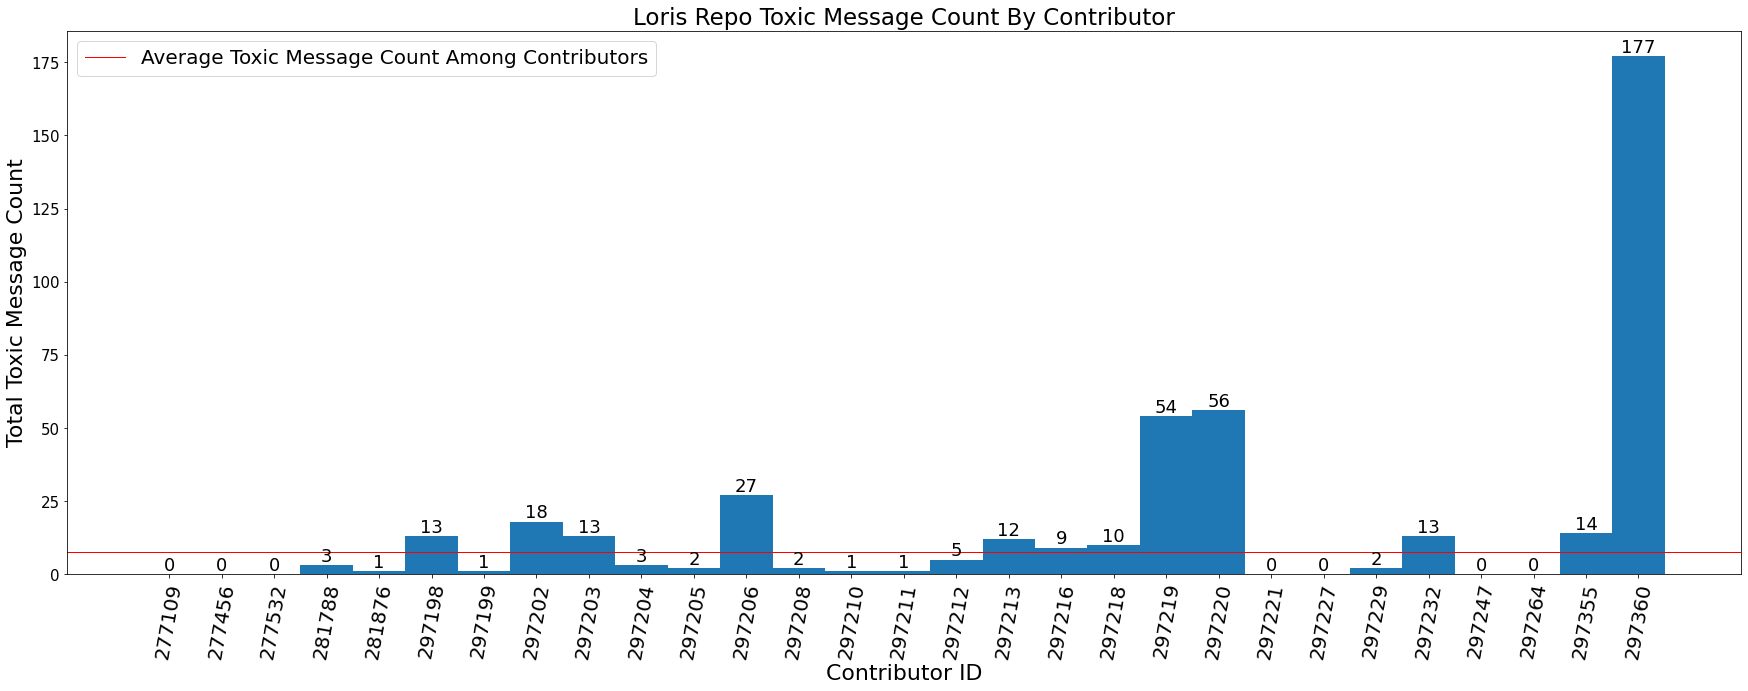

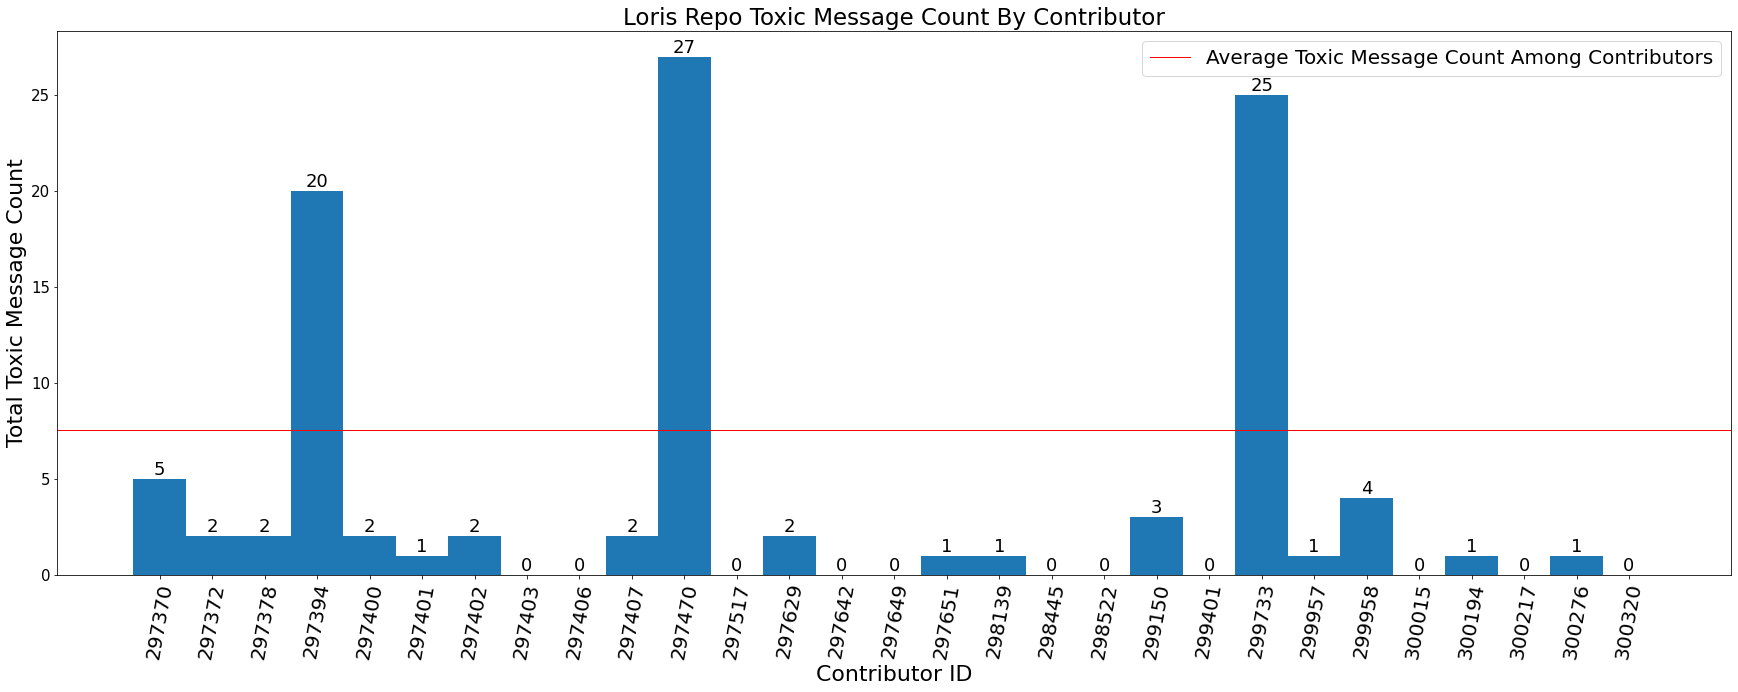

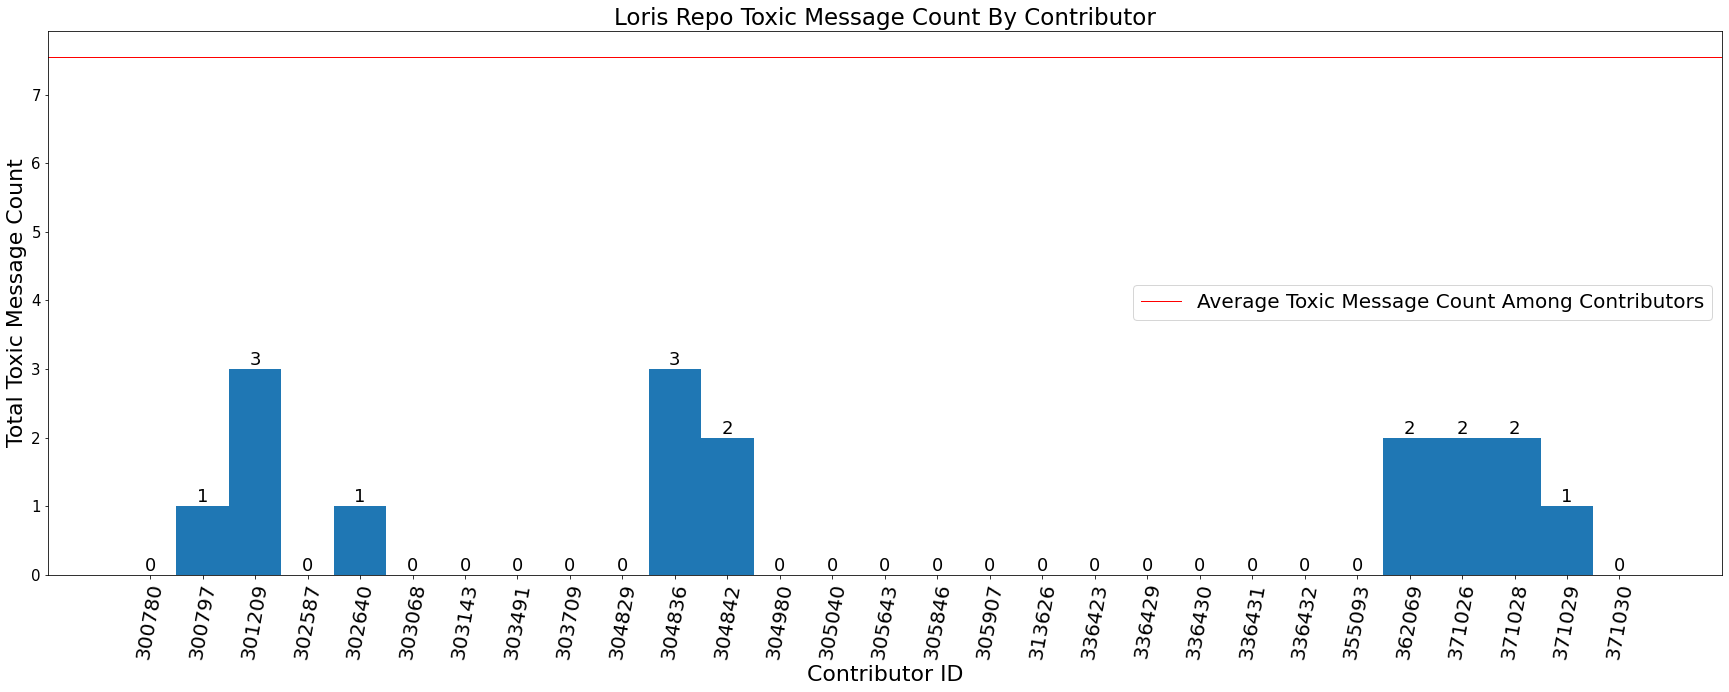

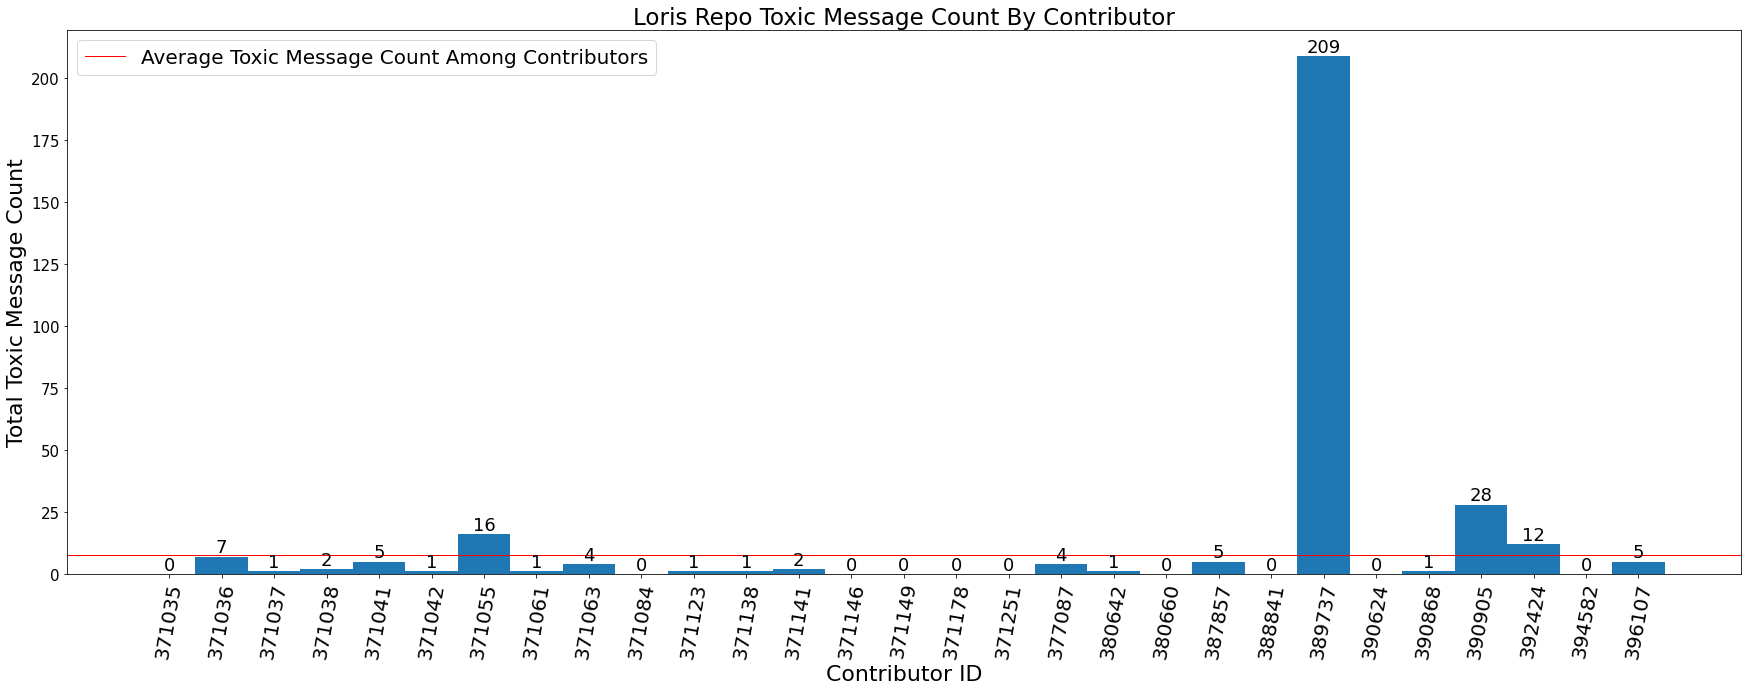

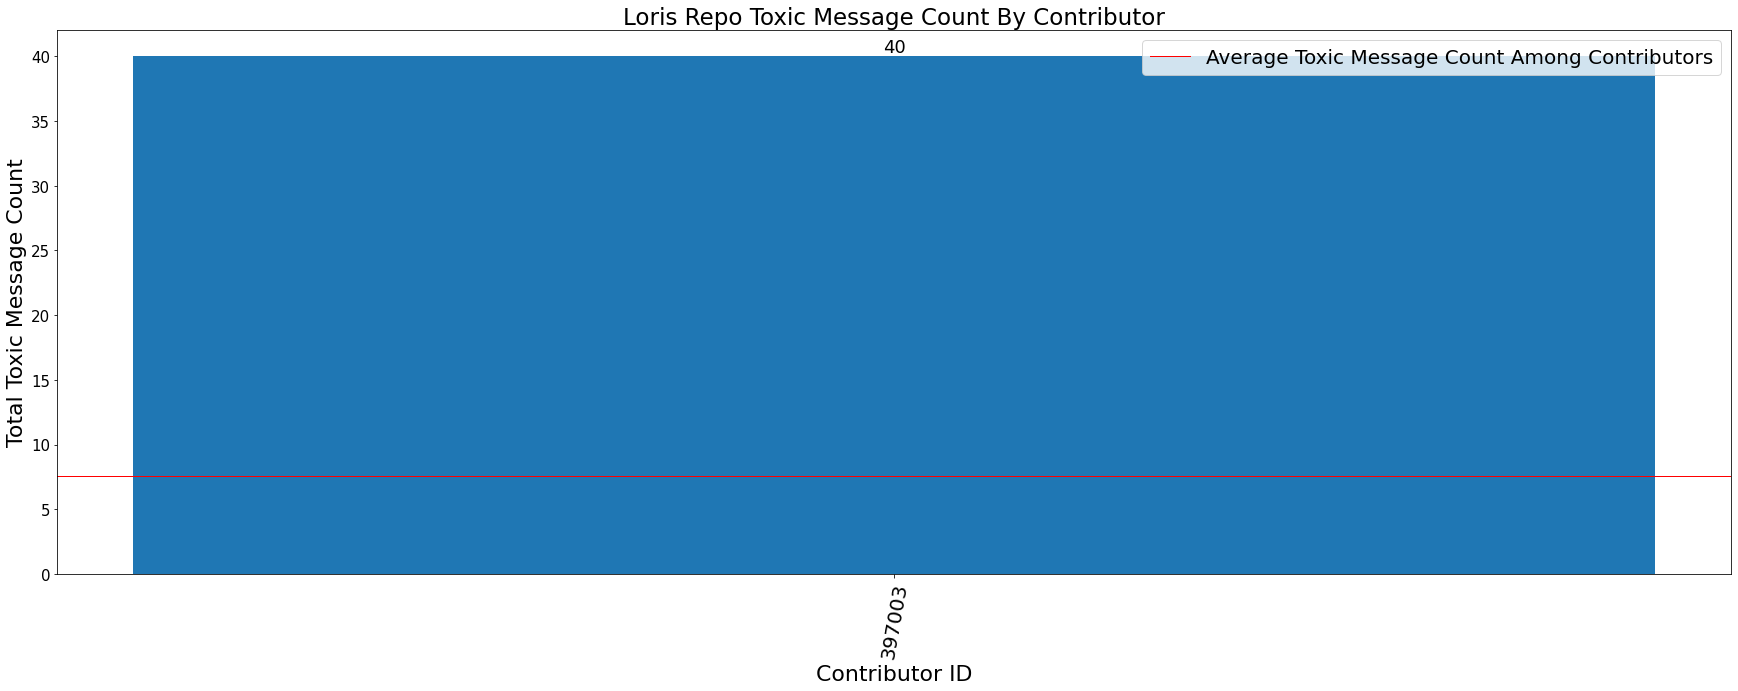

In [7]:
x = contribIDs
y = Toxic_Count_Array


length = len(x)
lower = 0;
upper = min(29, length)
while(upper < len(x)):
    if(lower > upper or lower >= length):
        break
    plt.figure(figsize=(30, 10))
    chart = plt.bar(x[lower:upper], y[lower:upper], 1)
    plt.title(repoName + " Repo Toxic Message Count By Contributor", fontsize=23)
    plt.xticks(fontsize=20, rotation=80)
    plt.yticks(fontsize=15)
    plt.xlabel("Contributor ID", fontsize=22)
    plt.ylabel("Total Toxic Message Count", fontsize=22)
    for i in plt.bar_label(chart):
        i.set_fontsize(18)
    meanLine = plt.axhline(y=average_toxic_count, linewidth=1, color='r', label='mean')
    plt.legend([meanLine], ["Average Toxic Message Count Among Contributors"], fontsize=20)
    plt.show()
    lower = lower + 30
    upper = upper + min(30, length - lower)



